# Notebook 3 — Simulator vs Hardware (IBM Runtime)
**Goal:** Run the same circuit on a simulator and on real IBM hardware (if available).

> Hardware access requires an IBM Quantum account and API token. See `00_Environment_Setup.md`.

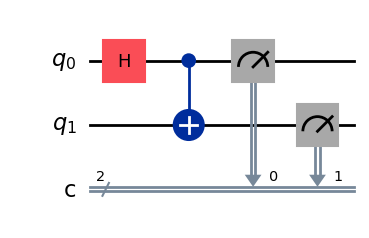

In [1]:
# Circuit: simple Bell state for hardware comparison
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

qc = QuantumCircuit(2, 2)
qc.h(0)
qc.cx(0, 1)
qc.measure([0,1], [0,1])
qc.draw('mpl')

Simulator counts: {'11': 1054, '00': 994}


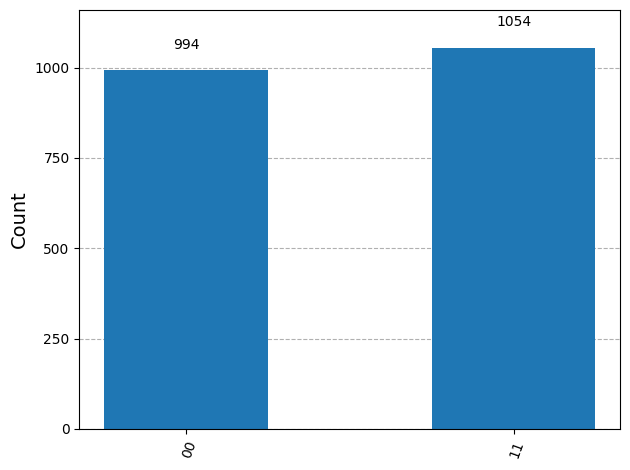

In [2]:
# --- Run on simulator
backend_sim = Aer.get_backend('qasm_simulator')
compiled_circuit = transpile(qc, backend_sim)
job = backend_sim.run(compiled_circuit, shots=2048)
sim_result = job.result()
sim_counts = sim_result.get_counts()
print("Simulator counts:", sim_counts)
plot_histogram(sim_counts)

In [7]:
# --- Try IBM Runtime (modern API). If unavailable, this cell will print a helpful message.
try:
    from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session

    # Initialize the service (requires saved account)
    service = QiskitRuntimeService()
    
    # Get available backends (try to find a real quantum backend)
    backends = service.backends(simulator=False, operational=True)
    if backends:
        backend = backends[0]  # Use the first available backend
        print(f"Selected backend: {backend.name}")
        
        # Create session and sampler (SamplerV2 approach)
        with Session(service=service, backend=backend) as session:
            sampler = SamplerV2(session=session)
            job = sampler.run([qc], shots=2048)
            hw_result = job.result()
            
            # Extract counts from SamplerV2 result
            pub_result = hw_result[0]  # First (and only) pub result
            hw_counts = pub_result.data.meas.get_counts()
            print("Hardware (SamplerV2) counts:", hw_counts)
    else:
        print("No real quantum backends available. Try using a simulator backend instead.")
        # Fallback to simulator
        sim_backends = service.backends(simulator=True)
        if sim_backends:
            backend = sim_backends[0]
            print(f"Using simulator backend: {backend.name}")
            
            with Session(service=service, backend=backend) as session:
                sampler = SamplerV2(session=session)
                job = sampler.run([qc], shots=2048)
                hw_result = job.result()
                
                pub_result = hw_result[0]
                hw_counts = pub_result.data.meas.get_counts()
                print("Simulator (via Runtime SamplerV2) counts:", hw_counts)
        else:
            print("No backends available through IBM Runtime")
            
except Exception as e:
    print("IBM Runtime path not available in this environment:", e)
    print("This usually means:")
    print("1. IBM Quantum account not set up (run setup_ibm_quantum.py)")
    print("2. No qiskit-ibm-runtime package installed (pip install qiskit-ibm-runtime)")
    print("3. No API token saved")
    print("4. Using older qiskit-ibm-runtime version (try: pip install --upgrade qiskit-ibm-runtime)")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-26 12:42:42,819: Default instance not set. Searching all available instances.


Selected backend: ibm_torino
IBM Runtime path not available in this environment: Session.__init__() got an unexpected keyword argument 'service'
This usually means:
1. IBM Quantum account not set up (run setup_ibm_quantum.py)
2. No qiskit-ibm-runtime package installed (pip install qiskit-ibm-runtime)
3. No API token saved
4. Using older qiskit-ibm-runtime version (try: pip install --upgrade qiskit-ibm-runtime)


In [6]:
# --- Alternative: Direct backend access (if you have qiskit-ibm-runtime)
try:
    from qiskit_ibm_runtime import QiskitRuntimeService
    
    service = QiskitRuntimeService()
    
    # Get a real quantum backend directly
    backend = service.backend('ibm_brisbane')  # Try a specific backend name
    print(f"Selected backend: {backend.name}")
    
    # Run job directly on backend (traditional approach)
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit, shots=2048)
    print("Job ID:", job.job_id())
    
    # This will likely queue - in a real workshop you'd wait or check status
    print("Job queued! In a real scenario you'd wait for completion...")
    print("Job status:", job.status())
    
except Exception as e:
    print("Direct backend access not available:", e)
    print("Common issues:")
    print("- Backend name doesn't exist or isn't available")
    print("- Account doesn't have access to that backend")
    print("- qiskit-ibm-runtime not installed")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-26 12:41:30,378: Default instance not set. Searching all available instances.


Selected backend: ibm_brisbane
Direct backend access not available: 'Support for backend.run() has been removed. Please see our migration guide https://quantum.cloud.ibm.com/docs/migration-guides/qiskit-runtime for instructions on how to migrate to the primitives interface.'
Common issues:
- Backend name doesn't exist or isn't available
- Account doesn't have access to that backend
- qiskit-ibm-runtime not installed


**Discussion**
- Compare simulator vs hardware results; notice noise on hardware.
- Talk about error sources and simple mitigation strategies.